In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import pickle
from random import shuffle
from pathlib import Path
# if using a Jupyter notebook, includue:
%matplotlib inline

In [3]:
Data = pd.read_feather('Data.feather')
pids = Data['pid'].unique()
pid_groups = Data.groupby('pid')
meta_covars = ['pid','SepsisLabel']
baseline_covars = []
lab_covars = []
vital_covars = ['HR','O2Sat','Temp','SBP','MAP','DBP', 'Resp']

C:\Users\choltz\AppData\Local\Continuum\anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [4]:
Data.columns

Index(['index', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'pid'],
      dtype='object')

40336
hospital stay length: mean 38.48200119000396 std 22.795923321200572


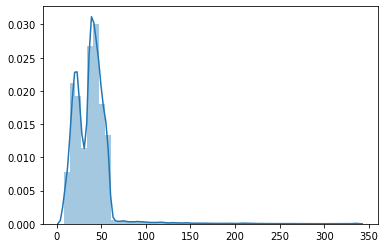

In [5]:
print(len(pids))
sns.distplot(pid_groups.size())
print('hospital stay length:', 'mean', pid_groups.size().mean(), 'std',pid_groups.size().std())

In [6]:
## prune hospital stay outliers:
pids_stay_length = pid_groups.size()
pids = pids_stay_length[np.abs(pids_stay_length-pids_stay_length.mean()) <= (3*pids_stay_length.std())]
pids = pids_stay_length[pids_stay_length > 7]

In [7]:
Data = Data[Data['pid'].isin(pids.index)]

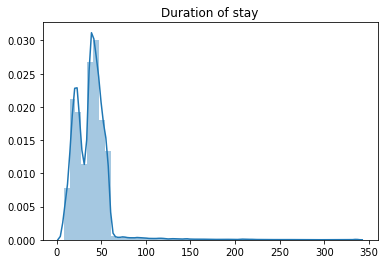

In [8]:
plt.title("Duration of stay")
sns.distplot(Data.groupby('pid').size())

In [9]:
## sepsis pids remove those who get into the hospital with sepsis
sepsis_pids = (Data.groupby('pid')['SepsisLabel'].sum() > 1)[(Data.groupby('pid')['SepsisLabel'].sum() > 1) == True].index.unique().tolist()
non_sepsis_pids = [pid for pid in pids.index if pid not in sepsis_pids]

In [11]:
len(sepsis_pids)

2927

In [ ]:
sns.distplot(Data[Data['pid'].isin(sepsis_pids)].groupby('pid').size())

In [ ]:
sns.distplot(Data[Data['pid'].isin(non_sepsis_pids)].groupby('pid').size())

In [ ]:
print(Data[Data['pid'].isin(sepsis_pids)].groupby('pid').size().mean())
print(Data[Data['pid'].isin(sepsis_pids)].groupby('pid').size().std())

In [13]:
print(Data[Data['pid'].isin(non_sepsis_pids)].groupby('pid').size().mean())
print(Data[Data['pid'].isin(non_sepsis_pids)].groupby('pid').size().std())

36.89646876420113
15.870526473682462


In [ ]:
print('sepsis:', len(sepsis_pids), 'not sepsis:', len(not_sepsis_pids))

In [ ]:
## time to sepsis
plt.title("Time to sepsis")
sns.distplot(Data[Data.pid.isin(sepsis_pids)].groupby('pid').size() - Data[Data.pid.isin(sepsis_pids)].groupby('pid').SepsisLabel.sum())

In [ ]:
# no sepsis in first 7 days
sepsis_pids = (Data[Data.pid.isin(sepsis_pids)].groupby('pid').size() - Data[Data.pid.isin(sepsis_pids)].groupby('pid').SepsisLabel.sum() > 7)[(Data[Data.pid.isin(sepsis_pids)].groupby('pid').size() - Data[Data.pid.isin(sepsis_pids)].groupby('pid').SepsisLabel.sum() > 7)].index.tolist()

In [ ]:
len(non_sepsis_pids)

In [14]:
Data = Data[Data.pid.isin(sepsis_pids + non_sepsis_pids)]

In [ ]:
## duration of sepsis
plt.title("Duration of sepsis")
sns.distplot(Data[Data.pid.isin(sepsis_pids)].groupby('pid').SepsisLabel.sum())

In [ ]:
## plots of sepsis cases vital covariates
(Data[Data['pid'] == sepsis_pids[3]]['SepsisLabel']*10).plot()
Data[Data['pid'] == sepsis_pids[3]][vital_covars + ['SepsisLabel']].plot()

In [ ]:
train_sample = Data.sample(frac=0.01)
plt.figure(figsize=(10,5))
plt.title("Distribution")
ax = sns.distplot(train_sample['HR'].dropna(), label='HR', kde=False, fit=stats.norm)
ax = sns.distplot(train_sample['Temp'].dropna(), label='TEMP', kde=False, fit=stats.norm)
ax = sns.distplot(train_sample['O2Sat'].dropna(), label='O2SAT)', kde=False, fit=stats.norm)
ax = sns.distplot(train_sample['MAP'].dropna(), label='MAP', kde=False, fit=stats.norm)
ax = sns.distplot(train_sample['DBP'].dropna(), label='DBP', kde=False, fit=stats.norm)
ax = sns.distplot(train_sample['SBP'].dropna(), label='SBP', kde=False, fit=stats.norm)
ax.legend()

In [ ]:
Data.isnull().sum()/Data.shape[0]

In [15]:
# parse covars - remove index, Unit1, Unit2, HospAdmTime
columns = Data.columns.tolist()
ignored_covars = ['Unit1', 'Unit2', 'HospAdmTime', 'index']

label = ['SepsisLabel']
vital_covars = ['HR','O2Sat','Temp','SBP','MAP','DBP', 'Resp']
idx_covars = ['pid']
baseline_covars = ['Age', 'Gender', 'ICULOS']
lab_covars = [col for col in columns if col not in ignore + label + vital_covars + idx_covars + baseline_covars]

NameError: name 'ignore' is not defined

In [27]:
class Dataset:
    def __init__(self):
        self.groups = {}
        self.sepsis_pids = []
        self.non_sepsis_pids = []
        for group_name in ('train', 'val', 'test'):
            self.groups[group_name] = {
                "pid_list": [],
                "vital_features_list": [],
                "baseline_features_list": [],
                "lab_features_list": [],
                "ignored_features_list": [],
                "labels_list": []
            }
        
    @classmethod
    def generate_pid_split(cls, data, split, balance_tr_data = False, sepisis_pids=None, non_sepsis_pids=None):
        # balance data by undersampling non-sepsis cases
        # split given as int
        self = cls()
        pids = data.pid.unique().tolist()
        shuffle(pids)
        if balance_tr_data:
            #sepisis_pids, non_sepsis_pids = pids
            spl = int(split * len(sepisis_pids))
            tst_pids = sepisis_pids[:spl]
            #val_pids = sepisis_pids[spl:2*spl]
            val_pids = []
            tr_pids = sepisis_pids[spl:]
            
            tst_pids.append(non_sepsis_pids[:spl])
            #val_pids.extend(non_sepsis_pids[spl:2*spl])
            tr_pids.extend(non_sepsis_pids[2*spl:2*spl+int(len(tr_pids)*1.5)])
            
        else:
            spl = int(split * len(pids))
            tst_pids = pids[:spl]
            val_pids = pids[spl:2*spl]
            tr_pids = pids[2*spl:]
        
        pid_grouped_data = data.groupby('pid')
        for pid, group in tqdm(pid_grouped_data, desc='splitting data...'):
            if pid in tr_pids:
                self.groups['train']['pid_list'].append(pid)
                self.groups['train']['vital_features_list'].append(group[vital_covars])
                self.groups['train']['baseline_features_list'].append(group[baseline_covars])
                self.groups['train']['lab_features_list'].append(group[lab_covars])
                self.groups['train']['ignored_features_list'].append(group[ignored_covars])
                self.groups['train']['labels_list'].append(group[label])
            elif pid in val_pids:
                self.groups['val']['pid_list'].append(pid)
                self.groups['val']['vital_features_list'].append(group[vital_covars])
                self.groups['val']['baseline_features_list'].append(group[baseline_covars])
                self.groups['val']['lab_features_list'].append(group[lab_covars])
                self.groups['val']['ignored_features_list'].append(group[ignored_covars])
                self.groups['val']['labels_list'].append(group[label])
            elif pid in tst_pids:
                self.groups['test']['pid_list'].append(pid)
                self.groups['test']['vital_features_list'].append(group[vital_covars])
                self.groups['test']['baseline_features_list'].append(group[baseline_covars])
                self.groups['test']['lab_features_list'].append(group[lab_covars])
                self.groups['test']['ignored_features_list'].append(group[ignored_covars])
                self.groups['test']['labels_list'].append(group[label])
        return self
    
    @classmethod
    def load(cls, filepath):
        filepath = Path(filepath)
        with filepath.open('rb') as f:
            return pickle.load(f)
        
    def save(self, filepath):
        filepath = Path(filepath)
        if filepath.exists():
            raise FileExistsError(f"cannot write dataset to '{filepath}'; file exists")
        
        with filepath.open('wb') as f:
            pickle.dump(self, f)


In [28]:
dataset = Dataset()

In [21]:
dataset.sepsis_pids = sepsis_pids
dataset.non_sepsis_pids = non_sepsis_pids

In [29]:
len(non_sepsis_pids)

37409

In [30]:
dataset = dataset.generate_pid_split(Data, 0.1, True, sepsis_pids, non_sepsis_pids)
dataset.save("./dataset_balanced.gpickle")

In [ ]:
len(Data.pid.unique())